Import stuff and initialize global parameters.

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Conv2D, Flatten, Dense, LSTM, \
    MaxPooling2D
from keras.models import Sequential
from common import extract_training_data_as_stacked
from car_interfacing import CarConnection
from sklearn.metrics import explained_variance_score

IMAGE_SIZE = (64, 64, 3)

Using TensorFlow backend.


# Convolutional network
Reading data as bundles and creating initial model.

In [4]:
images, labels = extract_training_data_as_stacked("Data/20171211-185037299.h264", 
                                                  "Data/20171211-185037299.csv", 
                                                  IMAGE_SIZE)

In [8]:
y_train = labels.as_matrix(columns=labels.columns[2: -1])
y_train.shape

(8725, 3)

In [9]:
def create_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu', input_shape=(64, 64, 12)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), kernel_initializer="he_normal", activation='relu'))
    model.add(Flatten())
    model.add(Dense(3, activation='linear'))

    model.compile(loss="mse", optimizer="adam")    
    return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 62, 62, 32)        3488      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 32)        9248      
__________

In [10]:
history = model.fit(images, y_train, batch_size=64, epochs=10, validation_split=0.04)

Train on 8376 samples, validate on 349 samples
Epoch 1/10
8376/8376 [==============================] - 159s - loss: 0.0857 - val_loss: 0.0155
Epoch 2/10
8376/8376 [==============================] - 166s - loss: 0.0464 - val_loss: 0.0026
Epoch 3/10
8376/8376 [==============================] - 167s - loss: 0.0394 - val_loss: 0.0071
Epoch 4/10
8376/8376 [==============================] - 172s - loss: 0.0351 - val_loss: 0.0122
Epoch 5/10
8376/8376 [==============================] - 163s - loss: 0.0316 - val_loss: 2.6474e-04
Epoch 6/10
8376/8376 [==============================] - 163s - loss: 0.0288 - val_loss: 8.5261e-04
Epoch 7/10
8376/8376 [==============================] - 165s - loss: 0.0272 - val_loss: 8.6778e-04
Epoch 8/10
8376/8376 [==============================] - 153s - loss: 0.0240 - val_loss: 4.9419e-04
Epoch 9/10
8376/8376 [==============================] - 154s - loss: 0.0228 - val_loss: 0.0021
Epoch 10/10
8376/8376 [==============================] - 154s - loss: 0.0212 - val

In [25]:
test_images, test_labels = extract_training_data_as_stacked("Data/20171029-201639.h264.avi", 
                                                            "Data/20171029-201639.h264.csv", 
                                                            IMAGE_SIZE)

prediction = model.predict(test_images)
prediction = model.predict(images)

### Convolutional network results
Testing prediction printout and graphs.

In [18]:
prediction

array([[ 0.00500449,  0.00968667,  0.85270411],
       [-0.04509272, -0.00742263,  0.86357337],
       [-0.02205142, -0.01641375,  0.85453337],
       ..., 
       [-0.40679494, -0.0584463 ,  0.5482927 ],
       [-0.60833544, -0.04449844,  0.57101506],
       [-0.8376047 , -0.06004648,  0.50584358]], dtype=float32)

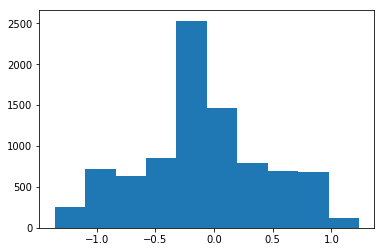

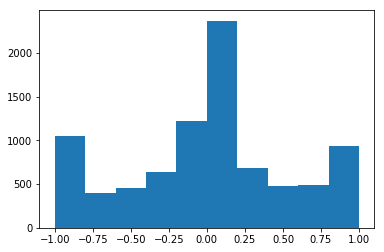

In [26]:
# Prediction histogram
plt.hist(prediction[:, 0])
plt.show()

# Test data
plt.hist(test_labels['Steering'])
plt.show()

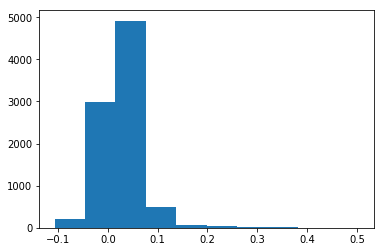

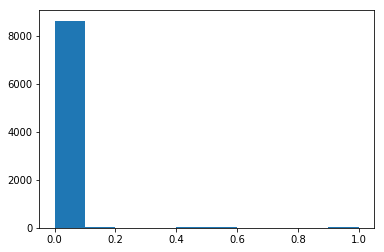

In [28]:
# Prediction histogram
plt.hist(prediction[:, 1])
plt.show()

# Test data
plt.hist(test_labels['Braking'])
plt.show()

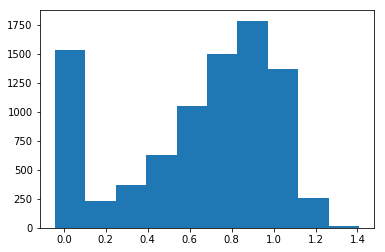

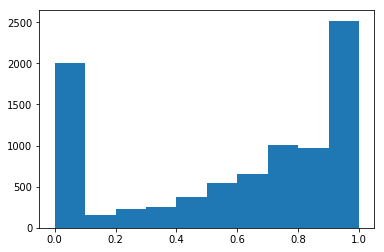

In [29]:
# Prediction histogram
plt.hist(prediction[:, 2])
plt.show()

# Test data
plt.hist(test_labels['Throttle'])
plt.show()

### Result analysis
Explained variance etc.

Firstly clip incorrect values back into known bounds. Afterwards find the explained variance.

In [30]:
validation_labels = test_labels.as_matrix(columns=test_labels.columns[1: -1])

clipped_prediction = np.zeros_like(prediction)

# Steering
clipped_prediction[:, 0] = np.clip(prediction[:, 0], -1, 1)
# Brakes
clipped_prediction[:, 1] = np.clip(prediction[:, 1], 0, 1)
# Throttle
clipped_prediction[:, 2] = np.clip(prediction[:, 2], 0, 1)

print(validation_labels.shape)
print(clipped_prediction.shape)

(8725, 3)
(8725, 3)


In [31]:
explained_variance_score(validation_labels, clipped_prediction)

0.68605540239345153

## K fold cross validation

In [ ]:
from common import run_kfold_cross_val

# Concatenate both videos
total_images = np.concatenate((images, test_images), axis=0)
total_labels = np.concatenate((labels, test_labels), axis=0)

total_y_train = total_labels[:, 1:-1]

results = run_kfold_cross_val(create_model, total_images, total_y_train)
print(results)
print(results.mean())
print(np.median(results))

## Saving model
Saves the model into a file and loads it again.

In [12]:
from keras.models import load_model

model.save('conv_dense_bigdata.h5')
del model
model = load_model('conv_dense_bigdata.h5')

In [ ]:
from PIL import Image
from keras.models import load_model

model = load_model('conv_dense_bigdata.h5')
connection = CarConnection()

frame_counter = 0
processed_frames = []

while True:
    frame_counter += 1
    
    # connect to 22241 and retreive rescaled frame
    frame = connection.receive_data_from_stream()
    
    if frame is not None:
        # Normalizing frame
        normed = frame / 255
        processed_frames.append(normed)
        
        if len(processed_frames) >= 4:
            stacked_image = np.concatenate(processed_frames, axis=2)
            prediction = model.predict(stacked_image[np.newaxis, :])
            
            pred_list = prediction.tolist()[0]
            pred_list.append(2)
            pred_list[1] = 0.0
            
            connection.send_commands_to_car(pred_list)
            processed_frames.pop(0)
            
    # Some breaking condition to kill me here
    if frame_counter >= 15000:
        break

connection.close()

In [4]:
connection.close()

OSError: [WinError 10038] An operation was attempted on something that is not a socket